# Création d'un grid de population à mailles de taille variable

## Python imports

Import des bibliothèques qui seront utiles à l'exécution du code.

- [SQLITE3](https://docs.python.org/3.8/library/sqlite3.html "SQLITE3") pour créer, interroger et mettre à jour des bases de données SQLITE (système de base de données qui simplifie le stockage et l’utilisation de données relationnelles); 
- [OS](https://docs.python.org/3/library/os.html "OS") pour utiliser les fonctionnalités dépendantes du système d'exploitation telles que lire ou écrire un fichier ou manipuler les chemins de fichiers;
- [Pandas](https://pandas.pydata.org/ "Pandas") pour la manipulation et l'analyse des données.
- [NumPy](https://numpy.org/ "NumPy") pour la manipulation des matrices ou tableaux multidimensionnels ainsi que des fonctions mathématiques opérant sur ces tableaux

In [1]:
import sqlite3
import os
import pandas as pd
import numpy as np

## Environment

Définitions de variables générales, d'un directory de travail et création d'une base de données spatiale vide.

In [2]:
if os.path.exists(f'output/varying-cell-size-grid.sqlite'):
     os.remove(f'output/varying-cell-size-grid.sqlite')

In [3]:
database = sqlite3.connect(f'output/varying-cell-size-grid.sqlite')
database.enable_load_extension(True)
database.load_extension("mod_spatialite")
database.execute('select InitSpatialMetaData(1);')
database.commit()

## Input data 

### 1. Population

Chargement des données de population dans la base de données. Ces données doivent se trouver dans un directory "input" au format csv (delimité par un "|"). 

Les données de population contiennent une personne par ligne, avec les coordonnées (x,y), un identifiant ménage et un identifiant personne. Ces données sont ici en **coordonnées ETRS89-extended / LAEA Europe - [EPSG:3035](https://epsg.io/3035 "EPSG:3035")**, qui est le système de coordonnées projetées utilisé pour l'Europe (pays de l'UE et candidats). 

Ces données ont été générées selon les critères suivants:
- zone à cheval sur le Brabant wallon, le Brabant flamand et Bruxelles
- points "personnes" placés sur les centroïdes des batiments repris dans les données du cadastre
- points répartis aléatoirement dans les batiments, en respectant la densité de population des secteurs statistiques
- création artificielle de ménages
- attribution d'ID_DEMO et d'ID_HH fictifs

Le code pour la génération de cet échantillon se trouve [ici]().

Le dataset **T06_SAMPLE** est lu et chargé directement dans la base de données sqlite (table **T01_POPULATION**).

In [5]:
df = pd.read_csv('input/synthetic_population/synthetic_population.csv',sep='|')
df.to_sql(name='T01_POPULATION',con=database,index=False,if_exists="replace")

210953

In [6]:
df.head(10)

,id_demo,id_hh,X,Y,cd_sector
0,0c048b3a434e49e6,0000608540e08433,3.928896e+06,3.093221e+06,21002A00-
1,138bb0696595b338,0000608540e08433,3.928896e+06,3.093221e+06,21002A00-
2,a1d0c6e83f027327,0000608540e08433,3.928896e+06,3.093221e+06,21002A00-
3,824cca8cfaf9469b,000065bda44347cc,3.936903e+06,3.086124e+06,23062A291
4,168908dd3227b835,000070a3e6444850,3.928749e+06,3.093286e+06,21002A00-
5,571d3a9420bfd921,000070a3e6444850,3.928749e+06,3.093286e+06,21002A00-
6,7a674153c63cff1a,000070a3e6444850,3.928749e+06,3.093286e+06,21002A00-
7,f752d6b2f21748e9,0000c9a8bcb9dc40,3.933418e+06,3.089979e+06,23062A411
8,f650dce1f77c2b8d,0000d912bbd27c62,3.933455e+06,3.084513e+06,23062A321
9,ba7163ef44a69630,0001fec9715c8f2e,3.933030e+06,3.090174e+06,23062A411


Vérification du nombre de personnes et de ménages dans la population:

In [7]:
pop = database.execute(f'''select count(*) as population from T01_POPULATION''').fetchone()[0]
hh = database.execute(f'''select count(distinct id_hh) as population from T01_POPULATION''').fetchone()[0]
print("N personnes:", pop, " - N ménages:", hh)

N personnes: 210953  - N ménages: 86299


Text(0.5, 1.0, 'Sample location in Belgium')

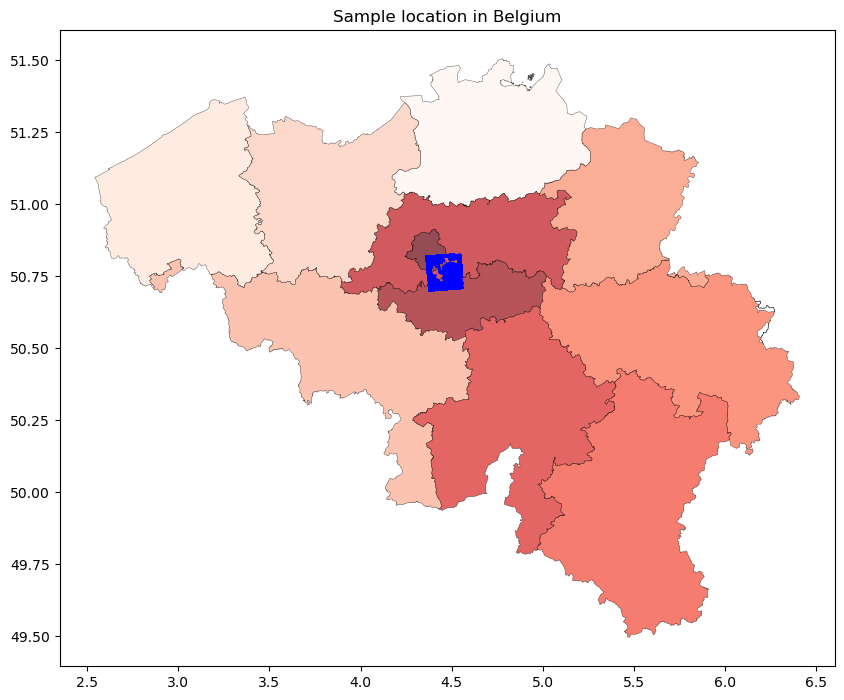

In [9]:
import matplotlib.pyplot as plot
import geopandas as gpd

gdf = gpd.GeoDataFrame(pd.read_csv('input/synthetic_population/synthetic_population.csv',sep='|'), geometry=gpd.points_from_xy(df.X, df.Y), crs="EPSG:3035")
gdf_wgs84 = gdf.to_crs(epsg=4326)

gdf_belgium = gpd.read_file('input/Apn_AdPr/Apn_AdPr.shp')
gdf_belgium_wgs84 = gdf_belgium.to_crs(epsg=4326)

fig, ax = plot.subplots(figsize=(10, 10))
gdf_belgium_wgs84.plot(ax=ax, column='NameFRE', cmap='Reds', edgecolor='black', linewidth=0.3, alpha=0.7) 
gdf_wgs84.plot(ax=ax, color="blue", marker='o', markersize=1.0)
ax.set_title("Sample location in Belgium")

### 2. Grid de base (taille des mailles 1000 m)

Partant des coordonées minimum et maximum de l'échantillon de test créé pour ce tutoriel (ci-dessus), une liste des coordonnées des coins inférieurs gauches des mailles de 1000 m qui englobent ces points est établie et stockée dans la table **T02_BASE_GRID**.

In [10]:
# Valeurs minimales et maximales de x et y
# Il est aussi possible de définir la zone d'étude en assignant les valeurs directement à nos variables
# Xmin, Xmax, Ymin, Ymax = 3924000, 3936000, 3081000, 3093000
minX = database.execute(f'''select cast(floor(min(X)/1000)*1000 as int) from T01_POPULATION''').fetchone()[0]
maxX = database.execute(f'''select cast(floor(max(X)/1000)*1000 as int) from T01_POPULATION''').fetchone()[0]
minY = database.execute(f'''select cast(floor(min(Y)/1000)*1000 as int) from T01_POPULATION''').fetchone()[0]
maxY = database.execute(f'''select cast(floor(max(Y)/1000)*1000 as int) from T01_POPULATION''').fetchone()[0]
minX, maxX, minY, maxY

(3924000, 3936000, 3081000, 3093000)

In [11]:
# Point spacing
x_spacing = 1000 
y_spacing = 1000

# Array avec les coordonnées X et Y
xcoords = [c for c in np.arange(minX, maxX+1, x_spacing)]
ycoords = [c for c in np.arange(minY, maxY+1, y_spacing)]

# Combinaison des array X et Y
grid_coords = []

for i in range(len(xcoords)):
    for j in range(len(ycoords)):
        grid_coords.append((xcoords[i], ycoords[j]))

# Stockage dans un dataframe
grid_df = pd.DataFrame.from_records(grid_coords, columns=['X','Y'])
print('Nombre de mailles de 1000 m:', len(grid_df))
grid_df.head()

Nombre de mailles de 1000 m: 169


,X,Y
0,3924000,3081000
1,3924000,3082000
2,3924000,3083000
3,3924000,3084000
4,3924000,3085000


<AxesSubplot: xlabel='X', ylabel='Y'>

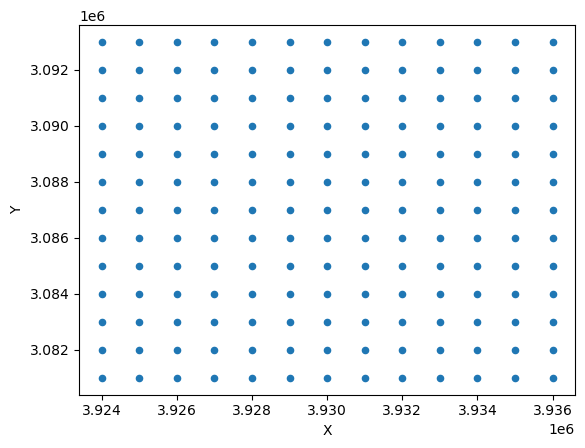

In [12]:
grid_df.plot.scatter(x='X', y='Y')

In [13]:
grid_df.to_sql(name='T02_BASE_GRID',con=database,index=False,if_exists="replace")

169

## Aggrégation des données par point XY

On groupe alors par coordonnées XY distinctes, pour obtenir une table **T03_POINTS** qui reprend une ligne par XY distinct et le nombre de personnes et de ménages pour ce point.

In [14]:
database.execute('drop table if exists T03_POINTS')
database.execute('''
                     create table T03_POINTS as
                     select X,
                            Y,
                            count(id_demo) as ms_population,
                            count(id_hh)   as ms_countof_hh
                     from T01_POPULATION
                     group by 1, 2
                ''')

Vérification du nombre de points:

In [15]:
pts = database.execute(f'''select count(*) as population from T03_POINTS''').fetchone()[0]
print("N points: ", pts)

N points:  79506


## Division des mailles

### 1. Création d'une table pour recevoir les résultats 

**T05_RESULTS** est la table qui va accueillir les mailles de taille variable:
 - (XY_X,XY_Y) sont les coordonnées du point inférieur gauche de la maille
 - MS_LENGTH est la longueur du côté de la maille
 - MS_POPULATION est la population qui vit dans la maille
 - MS_COUNTOF_HH est le nombre de ménages qui vivent dans la maille
 
 Elle va être alimentée par la table **T03_POINTS**.

In [16]:
database.execute('drop table if exists T05_RESULTS')
database.execute('''
                    create table T05_RESULTS (
                        X             integer,
                        Y             integer,
                        MS_LENGTH     integer,
                        MS_POPULATION integer,
                        MS_COUNTOF_HH integer  )
                ''')

### 2. Fonction de division itérative des mailles avec contrôle de confidentialité

Il faut maintenant attribuer à chaque point la plus petite maille qui peut le contenir. Les dimensions des mailles que l’on souhaite obtenir sont : 1000 x 1000m, 500 x 500m, 250 x 250m et 125 x 125m.

Pour qu'une maille soit divisée, il faut qu'il y ait:
- exactement 4 sous-mailles
- au moins 10 personnes et au moins 5 ménages dans chacune des 4 sous-mailles

Le calcul se base sur les coordonnées du coin inférieur gauche d'une maille, qui peut être vues comme un identifiant de celle-ci. Les unités de notre système de coordonnées sont en mètres. Pour chaque point, il est ainsi possible de déterminer le coin inférieur gauche de la maille de la façon suivante:
- Maille 1000 m : ```X,Y<sub>coin inf gauche</sub> = floor(X<sub>point</sub>/1000), floor(Y<sub>point</sub>/1000)```
- Maille 500 m :  ```X,Y<sub>coin inf gauche</sub> = floor(X<sub>point</sub>/500), floor(Y<sub>point</sub>/500)```
- Etc.

De façon itérative, il est alors possible de :
- déterminer les coordonnées du coin inférieur gauche de la maille de taille X (= parent)
- déterminer les coordonnées du coin inférieur gauche de la maille de taille X/2 (= enfant)
- attribuer un flag de confidentialité = group by sur chaque maille de taille X/2 *-> 1 si les critères ne sont pas rencontrés, 0 s'ils sont respectés*

Si les 4 sous-mailles enfant ne rencontrent pas les critères de confidentialité, cela signifie que la division est impossible, et qu'il faut garder la maille parent de taille X. Les mailles parent de taille X concernées sont dès lors copiées dans la table de résultats **T04_RESULTS** (aggrégation par maille parent du nombre de points et de ménages) et les points coorrespondants supprimés de la table de points **T03_POINTS**.

Cette procédure est réalisée pour toutes les tailles de sous-mailles souhaitées.

Une fonction a été écrite pour réalisé cette opération pour chaque dimension, ```l2``` correspondant à X et ```l1``` à X/2.

In [17]:
def tryToSplitCellsWithLength(l2):
    
    l1=int(l2/2)
    
    # division en 4 sous-mailles
    database.execute(f'drop table if exists T04_AGG_{l2}')
    database.execute(f'''
              create table T04_AGG_{l2} as
              select floor(X/{l2})*{l2}            as X_PARENT,
                     floor(Y/{l2})*{l2}            as Y_PARENT,
                     {l2}                          as MS_LENGTH_PARENT,
                     floor(X/{l1})*{l1}            as X,
                     floor(Y/{l1})*{l1}            as Y,
                     {l1}                          as MS_LENGTH,
                     sum(MS_POPULATION)            as MS_POPULATION,
                     sum(MS_COUNTOF_HH)            as MS_COUNTOF_HH,
                     case
                       when sum(MS_POPULATION)>=10 and sum(MS_COUNTOF_HH)>=5 then 0
                       else 1
                      end as FL_CONFIDENTIAL
               from T03_POINTS
               group by 1, 2, 3, 4, 5, 6
               ''')
    database.commit()
    
    # copie des mailles de taille l2 avec la population et le nombre de ménages
    database.execute(f'''
              insert into T05_RESULTS (X,Y,MS_LENGTH,MS_POPULATION,MS_COUNTOF_HH)
              select X_PARENT, Y_PARENT, MS_LENGTH_PARENT, sum(MS_POPULATION), sum(MS_COUNTOF_HH)
              from T04_AGG_{l2}
              group by 1, 2, 3
              having sum(not FL_CONFIDENTIAL)<4;
              ''')
    database.commit()

    # suppression de la table de points des points repris dans les mailles de taille l2 copiées ci-dessus dans les résultats
    database.execute(f'''
              delete from T03_POINTS
              where cast(floor(X/{l2})*{l2} as int)||'+'||cast(floor(Y/{l2})*{l2} as int) in (
               select distinct cast(X as int)||'+'||cast(Y as int) from T05_RESULTS)
              ''')
    database.commit()

### 3. Exécution de la fonction pour toutes les tailles de mailles

In [18]:
tryToSplitCellsWithLength(1000)
n1000 = database.execute('''select count(*) as remaining from T03_POINTS''').fetchone()[0]
print("N points restant: ", n1000)

N points restant:  69292


In [19]:
tryToSplitCellsWithLength(500)
n500 = database.execute('''select count(*) as remaining from T03_POINTS''').fetchone()[0]
print("N points restant: ", n500)

N points restant:  61598


In [20]:
tryToSplitCellsWithLength(250)
n250 = database.execute('''select count(*) as remaining from T03_POINTS''').fetchone()[0]
print("N points restant: ", n250)

N points restant:  47001


In [21]:
tryToSplitCellsWithLength(125)
n125 = database.execute('''select count(*) as remaining from T03_POINTS''').fetchone()[0]
print("N points restant: ", n125)

N points restant:  21223


### 4. Ajout des mailles de plus petite taille

Après avoir exécuté la fonction pour toutes les dimensions, nous avons pu stocker dans les résultats toutes les mailles de taille minimum allant jusqu'à 250 m. En effet, la dernière exécution étant pour la taille 125 m, le stockage des résultats a été réalisé pour les mailles qui ne peuvent pas être divisées vers des mailles de 125 m. Restent donc toutes les mailles de 125 m pour lesquelles les critères de confidentialité sont respectés.

Ces mailles sont donc ajoutées à la table de résultats **T05_RESULTS**, et la table de points **T03_POINTS** est alors totalement vide. 

In [22]:
database.execute(f'''
              insert into T05_RESULTS (X,Y,MS_LENGTH,MS_POPULATION,MS_COUNTOF_HH)
              select floor(X/125)*125, 
                     floor(Y/125)*125, 
                     125, 
                     sum(MS_POPULATION), 
                     sum(MS_COUNTOF_HH)
              from T03_POINTS
              group by 1, 2, 3''')
database.commit()

database.execute(f'''
              delete from T03_POINTS
              where cast(floor(X/125)*125 as int)||'+'||cast(floor(Y/125)*125 as int) in (
               select distinct cast(X as int)||'+'||cast(Y as int) from T05_RESULTS)
              ''')
database.commit()

In [23]:
n_remaining = database.execute(f'''select count(*) as remaining from T03_POINTS''').fetchone()[0]
print("N points restant: ", n_remaining)

N points restant:  0


### 5. Compléter le grid

Certains km² sont vide de toute population. Nous voulons, malgré tout, les avoir dans notre banque de données. On utilise pour cela la liste des mailles de taille 1000 m que nous avons créée au début du code (**T02_BASE_GRID**).

Les coins inférieurs gauche des mailles de 1000 m non présents dans la table de résultats **T05_RESULTS** sont ajoutés dans celle-ci.

In [24]:
database.execute(f'''
                  insert into T05_RESULTS (X,Y,MS_LENGTH,MS_POPULATION,MS_COUNTOF_HH)
                  select X    as X,
                         Y    as Y,
                         1000 as MS_LENGTH,
                         0    as MS_POPULATION,
                         0    as MS_COUNTOF_HH
                  from T02_BASE_GRID
                  where (X||Y) not in (SELECT (X||Y) FROM T05_RESULTS)
                ''')
database.commit()

In [25]:
grid_pop_df = pd.read_sql("""select X, Y from T05_RESULTS""", database)

<AxesSubplot: xlabel='X', ylabel='Y'>

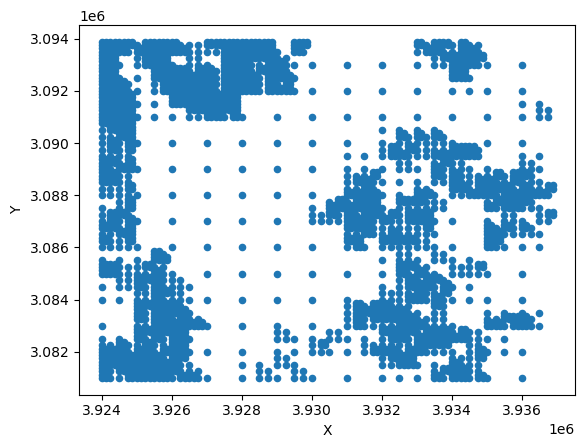

In [26]:
grid_pop_df.plot.scatter(x='X', y='Y')

# Résultats

### 1. Contrôles numériques

Vérification de la population totale (doit être égale à la population du fichier de départ)

In [27]:
res2=database.execute("select sum(ms_population) from T05_RESULTS").fetchone()[0]
print('Population totale (vérification) :',res2)

Population totale (vérification) : 210953


Ventilation de la population par taille de maille.

In [28]:
res=pd.read_sql("""select MS_LENGTH, count(*), sum(ms_population)
                   from T05_RESULTS
                   group by 1
                """, database)
res.head()

,MS_LENGTH,count(*),sum(ms_population)
0,125,2004,138537
1,250,411,33054
2,500,112,17978
3,1000,84,21384


Vérification de la confidentialité : les mailles avec moins de 10 personnes ou de 5 ménages sont confidentielles et ne peuvent pas être divisées; doivent être uniquement de taille 1000 m.

In [29]:
pd.read_sql("""
                  SELECT X, 
                         Y,
                         MS_LENGTH,
                         sum(MS_POPULATION)
                  FROM T05_RESULTS
                  where ms_population<10 and ms_population>0
                  group by 1, 2, 3
            """,
            database)

,X,Y,MS_LENGTH,sum(MS_POPULATION)
0,3926000,3086000,1000,1
1,3928000,3087000,1000,7
2,3928000,3088000,1000,4
3,3929000,3085000,1000,4
4,3930000,3091000,1000,3
5,3930000,3092000,1000,3
6,3932000,3092000,1000,6
7,3935000,3091000,1000,1


In [30]:
pd.read_sql("""
                  SELECT X, 
                         Y,
                         MS_LENGTH,
                         sum(MS_COUNTOF_HH) as ms_hh
                  FROM T05_RESULTS
                  where ms_countof_hh<5 and ms_countof_hh>0
                  group by 1, 2, 3
            """,
            database)

,X,Y,MS_LENGTH,ms_hh
0,3926000,3086000,1000,1
1,3928000,3088000,1000,4
2,3929000,3085000,1000,4
3,3930000,3091000,1000,3
4,3930000,3092000,1000,3
5,3935000,3091000,1000,1


### 2. Conversion des mailles en géométries

Ce query a pour but de créer une table contenant les mailles au format ```geometry```, de type polygone. 

Connaissant les coordonnées du coin inférieur gauche de chaque maille et la longueur de côté de celle-ci, il est possible de calculer les coordonnées des 3 points manquant pour reconstituer la surface de la maille. 

In [31]:
database.execute('drop table if exists POP_GRID_3035')
database.execute('''
                    create table POP_GRID_3035 as
                    select *,
                           '1kmN'||cast(floor(Y/1000) as int)||'E'||cast(floor(X/1000) as int) as grid_id,
                           CastToMultiPolygon(
                              ST_GeomFromText('POLYGON(('||cast(x           as int)||' '||cast(y           as int)||','
                                                         ||cast(x+MS_LENGTH as int)||' '||cast(y           as int)||','
                                                         ||cast(x+MS_LENGTH as int)||' '||cast(y+MS_LENGTH as int)||','
                                                         ||cast(x           as int)||' '||cast(y+MS_LENGTH as int)||','
                                                         ||cast(x           as int)||' '||cast(y           as int)||'))',3035))
                              as geometry
                    from T05_RESULTS
''')

In [32]:
database.execute("select recovergeometrycolumn('POP_GRID_3035', 'geometry',3035,'MULTIPOLYGON','XY')").fetchone()
database.execute("select createSpatialIndex('POP_GRID_3035', 'geometry')").fetchone()

(1,)

### Clean database 

In [33]:
database.execute("drop table if exists T01_POPULATION")
database.execute("drop table if exists T02_BASE_GRID")
database.execute("drop table if exists T03_POINTS")
database.execute("drop table if exists T04_AGG_1000")
database.execute("drop table if exists T04_AGG_500")
database.execute("drop table if exists T04_AGG_250")
database.execute("drop table if exists T04_AGG_125")
database.execute("drop table if exists T05_RESULTS")

In [34]:
database.execute("VACUUM")

## Export to shapefile and geojson

In [35]:
sql = f"""
SELECT x, y, ms_length as ms_len, ms_population as ms_pop, ms_countof_hh as ms_hh, 
       ST_AsBinary(geometry) as geometry
FROM POP_GRID_3035"""

gdf = gpd.GeoDataFrame.from_postgis(sql, database, geom_col='geometry',crs=3035)

In [36]:
print(gdf.crs)

epsg:3035


In [37]:
gdf.to_file('output/POP_GRID_3035.shp')

In [38]:
gdf.to_file('output/POP_GRID_3035.geojson', driver='GeoJSON')

Fermeture de la connexion à la base de données

In [39]:
database.close()